# Investigating MO distance distributions in MAC

In the proof of concept notebook, we notice that the MO 'energy' distances follow a peculiar, almost discontinuous distribution. The purpose of this notebook is to get to elucidate the origin of this discontinuity. 

Energy spectrum contains degeneracies =  False


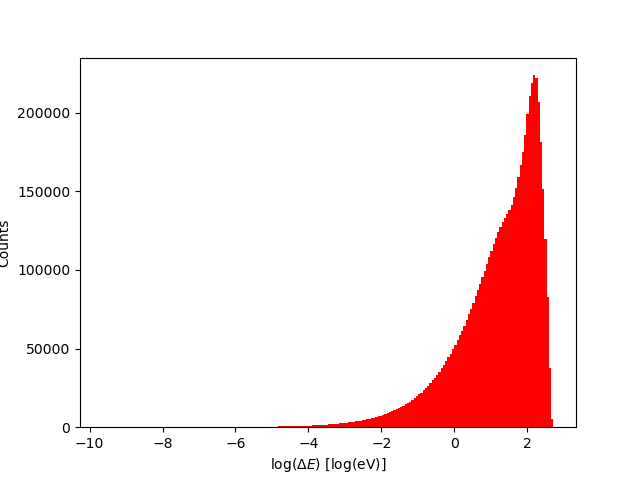

In [5]:
%matplotlib widget

from os import path
import numpy as np
import matplotlib.pyplot as plt
from qcnico.molecule import Molecule
from qcnico import plt_utils

def get_absdiffs(arr):
    """Compute the absolute value of differences between elements of a 1D array.
    To avoid redundancy when histograming; only upper triangular (excluding the main diagonal) is returned."""
    return np.triu(np.abs(arr[:,None] - arr[None,:]),1)

def isdegenerate(energies,tol=27.2114 * 1e-8, return_absdiffs=False):
    """Returns `True` if `energies` contains the same value more than once (up to precision `tol`).
    The default value of `tol` is set to what it is because QCFFPI offers an energy of 1e-8 Ha, and 
    the energies we are working with have usually been converted to eV (1 Ha = 27.2114 eV)."""
    absdiffs = get_absdiffs(energies)
    Nnnz = np.sum(absdiffs > tol)
    N = energies.size
    isdegen =  Nnnz != (N**2 - N) // 2
    if return_absdiffs:
        return isdegen, absdiffs
    else:
        return isdegen


datadir = path.expanduser('~/Desktop/simulation_outputs/qcffpi_data/MO_dynamics/300K_initplanar_norotate/')

mac = Molecule('frame-80000', datadir)
#pos, M = mac.fetch_pos_MOs()
mac.fetch_energies(prefix='orb_energy_')
ee = mac.energies

isdgen, ediffs = isdegenerate(ee, return_absdiffs=True)
print('Energy spectrum contains degeneracies = ', isdgen)
ediffs = ediffs[ediffs > 0]
plt_utils.histogram(np.log(ediffs), nbins=200, xlabel='log($\Delta E$) [log(eV)]')





In [ ]:
from numba import njit

@njit
def log_distance(ei, ej, mu=0, T=300):
    kB = 8.617e-5
    return (np.abs(ei-mu) + np.abs(ej-mu) + np.abs(ej-ei)) / (2*kB*T) 

@njit
def dArr_logE(e):
    N = e.size
    darr = np.zeros(N*(N-1)//2)

    k = 0
    
    for i in range(N):
        for j in range(i):
            darr[k] = log_distance(e[i], e[j])
            k+=1
    
    return darr